<h1>Notbook do analizy wyników algorytmu SA dla 1200 próbek po od 4-15 miast wykonanych dla różnych wartości warametrów alpha i beta z przedziału 0.1 - 0.9</h1>

1. Import bibliotek

In [1]:
import pandas as pd
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from builders.PathBuilder import PathBuilder
from constants.AlgNamesResults.names import *
from os.path import exists
import seaborn as sns
%matplotlib inline

2. Przygotowanie zmiennych do ekstrakcji danych z plików CSV

In [2]:
MEASUREMENTS = "measurements"
NAME_DIR_WITH_RESULTS_CSV = "simulated_annealing_alpha_range_from_0_1_to_0_99"
CSV = "csv"
CPU = "CPU"
TIME_AND_DATA = "TIME_AND_DATA"
TIME_AND_MEMORY = "TIME_AND_MEMORY"
NUMBER_OF_CITIES_COL = "number_of_cities"
INDEX_OF_SAMPLE_COL = "index_of_sample"
DEFAULT_COLUMNS = ["number_of_cities", "index_of_sample",]
FEATURE_COLUMNS = []
BASIC_COLUMNS = DEFAULT_COLUMNS + FEATURE_COLUMNS
CPU_COLUMNS = BASIC_COLUMNS + [
    "min_utilization_of_cpu",
    "avg_utilization_of_cpu",
    "max_utilization_of_cpu",
]
TIME_AND_DATA_COLUMNS = BASIC_COLUMNS + [
                                           "best_way_is_optimal",
                                           "relative_distance_error",
                                          ]
TIME_AND_MEMORY_COLUMNS = BASIC_COLUMNS + [
    "used_memory_before_measurement_in_bytes",
    "used_memory_peak_before_measurement_in_bytes",
    "used_memory_after_measurement_in_bytes",
    "used_memory_peak_after_measurement_in_bytes",
    "used_memory_diff_before_after_measurement_in_bytes",
    "used_memory_peak_diff_before_after_measurement_in_bytes",
    "time_duration_is_sec"
]
#NAME OF PARAMETERS
ALPHA = "ALPHA"
BETA = "BETA"
CSV_NAME = "CSV_NAME"

ALPHA_RANGE = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97,0.98, 0.99]
BETA_RANGE = [1]
PATTERN_SUFFIX = "%s_SA_ALPHA_%s_PERTURBATION_SCHEME_two_opt"
SIZE_OF_POPULATION = 100
NUMBER_OF_ITERATIONS = 100

3. Przygotowanie klasy do ekstrakcji danych z plików CSV

In [3]:
class CsvDataObject:
    def __init__(self, csv_name, alpha):
        self._csv_name = csv_name
        self._alpha = alpha
        self._global_path_to_csv = None
        self._parameters_dict = {
            CSV_NAME: csv_name,
            ALPHA: alpha
        }
        self._data_frame = None

    def __hash__(self):
        return hash((self._csv_name, self._alpha))


    @property
    def csv_name(self):
        return self._csv_name


    @property
    def alpha(self):
        return self._alpha

    @property
    def parameters_dict(self):
        return self._parameters_dict

    @property
    def data_frame(self):
        return self._data_frame

    @data_frame.setter
    def data_frame(self, value):
        self._data_frame = value

    @property
    def global_path_to_csv(self):
        return self._global_path_to_csv

    @global_path_to_csv.setter
    def global_path_to_csv(self, value):
        self._global_path_to_csv = value

4. Przygotowanie funkcji do ekstrakcji danych z plików CSV

In [4]:
def float_to_str(float_value=0.0):
    return str(float_value).replace(".", "_")

def generate_name_of_csv(type_measurement="", alpha=0.1):
    # CPU_SA_ALPHA_0_8_PERTURBATION_SCHEME_two_opt
    pattern_suffix = PATTERN_SUFFIX
    alpha_str = float_to_str(alpha)
    return pattern_suffix % (type_measurement, alpha_str)

def generate_config_combinations(type_of_measure=""):
    CONFIGURATIONS = list()
    pattern_suffix = PATTERN_SUFFIX
    size_population_range = SIZE_OF_POPULATION
    alpha_range = ALPHA_RANGE
    beta_range = BETA_RANGE
    number_of_iterations_range = NUMBER_OF_ITERATIONS
    for alpha in alpha_range:
        tmp_dictionary = dict()
        tmp_dictionary[ALPHA] = alpha
        alpha_str = float_to_str(alpha)
        #TO UPDATE
        name_of_csv = generate_name_of_csv(type_measurement=type_of_measure,
                                            alpha=alpha_str,
                                            )
        CONFIGURATIONS.append(CsvDataObject(csv_name=name_of_csv, alpha=alpha))
    return CONFIGURATIONS

def get_column_list(type_measurement=""):
    switcher = {
        TIME_AND_DATA: TIME_AND_DATA_COLUMNS,
        CPU: CPU_COLUMNS,
        TIME_AND_MEMORY: TIME_AND_MEMORY_COLUMNS
    }
    return switcher[type_measurement]

def prepare_csv_data_objects(type_of_measure, name_of_dir_with_meassurements, names_of_parameters=[]):
    result_list= list()
    names = list()
    for csv_file_config in generate_config_combinations(type_of_measure):
        path_to_csv = PathBuilder()\
            .add_dir(MEASUREMENTS)\
            .add_dir(name_of_dir_with_meassurements)\
            .add_file(csv_file_config.csv_name, "csv")\
            .build()
        csv_file_config.global_path_to_csv = path_to_csv
        if exists(path_to_csv):
            name_of_csv_file = csv_file_config.parameters_dict[CSV_NAME]
            names.append(name_of_csv_file)
            tmp_df = pd.read_csv(path_to_csv)
            tmp_df.dropna(axis=1, inplace=True)
            tmp_df.replace("Nan", "", inplace=True)
            for parameter_name in names_of_parameters:
                if parameter_name in csv_file_config.parameters_dict:
                    tmp_df.insert(2, parameter_name, [csv_file_config.parameters_dict[parameter_name]] * tmp_df.count()[0], True)
            csv_file_config.data_frame = tmp_df[get_column_list(type_of_measure)]
            result_list.append(csv_file_config)
    return result_list, names

def preapre_dictionary_to_heat_map_for_nr_cities_and_index_samples(data_frame=None, feature_to_heat_map=""):
    DICTIONARY_TO_HEAT_TABLE = dict()
    for row in data_frame.iterrows():
        row = row [1]
        number_of_cities = row[NUMBER_OF_CITIES_COL]
        index_of_sample = row[INDEX_OF_SAMPLE_COL]
        feature_value = row[feature_to_heat_map]
        if number_of_cities not in DICTIONARY_TO_HEAT_TABLE:
            DICTIONARY_TO_HEAT_TABLE[number_of_cities] = list()
        DICTIONARY_TO_HEAT_TABLE[number_of_cities].append(feature_value)
    return DICTIONARY_TO_HEAT_TABLE

5. Prezentacja danych z przykładowego pliku CSV

In [5]:
CSV_DATA_OBJECTS, NAMES = prepare_csv_data_objects(
    type_of_measure=TIME_AND_MEMORY,
    name_of_dir_with_meassurements=NAME_DIR_WITH_RESULTS_CSV,
    names_of_parameters=[ALPHA])
print(*NAMES, sep = "\n")

name_of_csv_file = generate_name_of_csv(type_measurement=TIME_AND_MEMORY, alpha=0.1)
path_to_csv = PathBuilder()\
            .add_dir(MEASUREMENTS)\
            .add_dir(NAME_DIR_WITH_RESULTS_CSV)\
            .add_file(name_of_csv_file, "csv")\
            .build()
print(path_to_csv)
df = pd.read_csv(path_to_csv)
df = df[TIME_AND_MEMORY_COLUMNS]
df

TIME_AND_MEMORY_SA_ALPHA_0_1_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_2_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_3_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_4_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_5_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_6_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_7_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_8_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_9_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_91_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_92_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_93_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_94_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_95_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_96_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_97_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPHA_0_98_PERTURBATION_SCHEME_two_opt
TIME_AND_MEMORY_SA_ALPH

,number_of_cities,index_of_sample,used_memory_before_measurement_in_bytes,used_memory_peak_before_measurement_in_bytes,used_memory_after_measurement_in_bytes,used_memory_peak_after_measurement_in_bytes,used_memory_diff_before_after_measurement_in_bytes,used_memory_peak_diff_before_after_measurement_in_bytes,time_duration_is_sec
0,4,0,0,0,19108,19108,19108,19108,0.341522
1,4,1,0,0,19108,19108,19108,19108,0.022540
2,4,2,0,0,19108,19108,19108,19108,0.050501
3,4,3,0,0,19108,19108,19108,19108,0.044030
4,4,4,0,0,19108,19108,19108,19108,0.048998
...,...,...,...,...,...,...,...,...,...
1195,15,95,0,0,19452,19452,19452,19452,0.257154
1196,15,96,0,0,19452,19452,19452,19452,0.306214
1197,15,97,0,0,19452,19452,19452,19452,0.525862
1198,15,98,0,0,19452,19452,19452,19452,0.403649


6. Dane minimalnego, średniego i maksymalnego zużycia CPU z przykładowego pliku dla danej liczby miast i indeksy próbki

In [6]:
DICTIONARY_TO_HEAT_TABLE =\
preapre_dictionary_to_heat_map_for_nr_cities_and_index_samples(data_frame=df,
                                                               feature_to_heat_map="used_memory_peak_diff_before_after_measurement_in_bytes")
df2 = pd.DataFrame.from_dict(DICTIONARY_TO_HEAT_TABLE)
df2
        

,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
0,19108.0,19148.0,19172.0,19204.0,19276.0,19300.0,19324.0,19207.0,19372.0,19396.0,19420.0,19452.0
1,19108.0,19085.0,19172.0,19204.0,19276.0,19300.0,19324.0,19260.0,19372.0,19396.0,19420.0,19452.0
2,19108.0,19148.0,19172.0,19204.0,19276.0,19300.0,19324.0,19260.0,19372.0,19396.0,19420.0,19452.0
3,19108.0,19148.0,19172.0,19204.0,19276.0,19300.0,19324.0,19260.0,19372.0,19396.0,19367.0,19452.0
4,19108.0,19148.0,19172.0,19204.0,19276.0,19300.0,19324.0,19260.0,19372.0,19396.0,19420.0,19452.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,19045.0,19148.0,19172.0,19204.0,19276.0,19300.0,19271.0,19260.0,19372.0,19396.0,19420.0,19452.0
96,19108.0,19148.0,19109.0,19204.0,19276.0,19300.0,19324.0,19260.0,19372.0,19396.0,19420.0,19452.0
97,19108.0,19148.0,19172.0,19204.0,19276.0,19300.0,19324.0,19260.0,19372.0,19396.0,19420.0,19452.0
98,19108.0,19148.0,19172.0,19204.0,19276.0,19300.0,19324.0,19260.0,19372.0,19396.0,19420.0,19452.0


7. Mapa ciepła minimalnego zużycia CPU z przykładowego pliku dla danej liczby miast i indeksy próbki

Text(0.0, 1.0, 'MINIMALNE, ŚEDNIE ORAZ JEDNOCZEŚNIE MAKSYMALNE ZUŻYCIE CPU DLA ALGORYTMU SA Z PARAMETREM ALFA= 0.1')

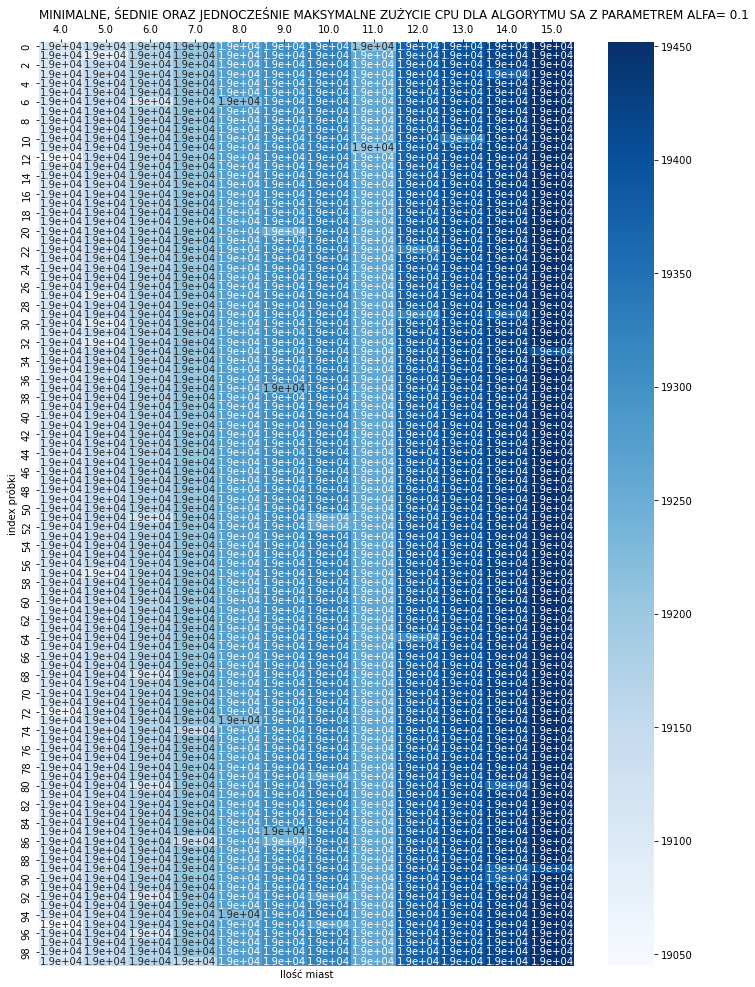

In [7]:
fig, ax = plt.subplots(figsize=(12,17))  
sns.heatmap(df2, cmap="Blues", annot=True, ax=ax)
ax.xaxis.tick_top()
# xticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# yticks_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
# plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Ilość miast')
plt.ylabel('index próbki')

# title
title = 'Minimalne, śednie oraz jednocześnie maksymalne zużycie CPU dla algorytmu SA z parametrem alfa= 0.1'.upper()
plt.title(title, loc='left')
# plt.savefig('time_exec_diagram.png')

8. Opracowanie funkcji do zliczania danych

In [8]:
from typing import List


def generate_value_of_parameter_to_df_dictionary(csv_data_objects: List[CsvDataObject], name_of_parameter=""):
    csv_results_by_feature = dict()
    for csv_data_object in csv_data_objects:
        if name_of_parameter in csv_data_object.parameters_dict:
            value_of_parameter = csv_data_object.parameters_dict[name_of_parameter]
            df = csv_data_object.data_frame
            if value_of_parameter not in csv_results_by_feature:
                csv_results_by_feature[value_of_parameter] = dict()
                csv_results_by_feature[value_of_parameter]= df
            else:
                csv_results_by_feature[value_of_parameter] = df
    return csv_results_by_feature

def get_stat_from_series(series, stat):
    if stat == "min":
        return series.min()
    elif stat == "avg":
        return series.mean()
    elif stat == "max":
        return series.max()
    elif stat == "stdev":
        return series.std()
    elif stat == "sum":
        return series.sum()
    elif stat == "log_sum":
        return math.log(series.sum())
    elif stat == "q1":
        return series.quantile(.25)
    elif stat == "q3":
        return series.quantile(.75)
    true_false_percentage = series.value_counts(normalize=True, ascending = True)
    if stat == "optimal_to_all_percentage":
        return true_false_percentage[0]
    elif stat == "not_optimal_to_all_percentage":
        return true_false_percentage[1]
    return np.nan

def generate_dictionary_by_rows_with_specific_value_and_by_stats_from_feature(csv_data_objects: List[CsvDataObject],
                                       name_of_parameter="",
                                       column_name="",
                                       values_of_column_name=[],
                                       feature_column_name="",
                                       stat=""):
    csv_results_by_features = dict()
    parameters_values =list()
    for csv_data_object in csv_data_objects:
        if name_of_parameter in csv_data_object.parameters_dict:
            value_of_parameter = csv_data_object.parameters_dict[name_of_parameter]
            parameters_values.append(value_of_parameter)
            df = csv_data_object.data_frame
            for value_of_column in values_of_column_name:
                filtered_rows_df = df[df[column_name] == value_of_column]
                series = filtered_rows_df[feature_column_name]
                value = get_stat_from_series(series=series, stat=stat)
                if value_of_column not in csv_results_by_features:
                    csv_results_by_features[value_of_column] = list()
                    csv_results_by_features[value_of_column].append(value)
                else:
                    csv_results_by_features[value_of_column].append(value)
    return csv_results_by_features, parameters_values



def generate_dictionary_data_frame_with_stats_from_feature(csv_data_objects: List[CsvDataObject],
                                                           name_of_parameter = "",
                                                           name_of_feature_column ="",
                                                           stat=""):
    # [NUMBER_OF_CITIES][4]-[15]
    # [0][MIN_RELATIVE_DISTANCE_ERROR]
    # .
    # [99]
    TABLE = dict()
    for csv_data_object in csv_data_objects:
        if name_of_parameter in csv_data_object.parameters_dict:
            value_of_parameter = csv_data_object.parameters_dict[name_of_parameter]
            df = csv_data_object.data_frame
            series = df[name_of_feature_column]
            value = get_stat_from_series(series, stat)
            if value_of_parameter not in TABLE:
                TABLE[value_of_parameter] = list()
                TABLE[value_of_parameter].append(value)
            else:
                TABLE[value_of_parameter].append(value)
    return TABLE


def count_heat_table_values(heat_map_dictionary, type=""):
    new_dict = heat_map_dictionary.copy()
    for key in heat_map_dictionary.keys():
        list_values = heat_map_dictionary[key]
        if type == "bytes_to_mb":
            list_values = [x / 1024 for x in list_values]
        elif type == "bytes_to_gb":
            list_values = [x / (1024 * 1024) for x in list_values]
        elif type == "bytes_to_tb":
            list_values = [x / (1024 * 1024 * 1024) for x in list_values]
        new_dict[key] = list_values
    return new_dict

9. Przygotowanie mapy ciepła dla danej wartości parametrów alfa obrazującą minimalne zużycie CPU zależne od ilości miast oraz wartośći parametru ALFA

Text(0.0, 1.0, 'MINIMALNE ZUŻYCIE PAMIĘCI RAM W MB DLA ALGORYTMU SA DLA DANEJ LICZBY MIAST ORAZ WARTOŚCI PARAMETRU ALFA')

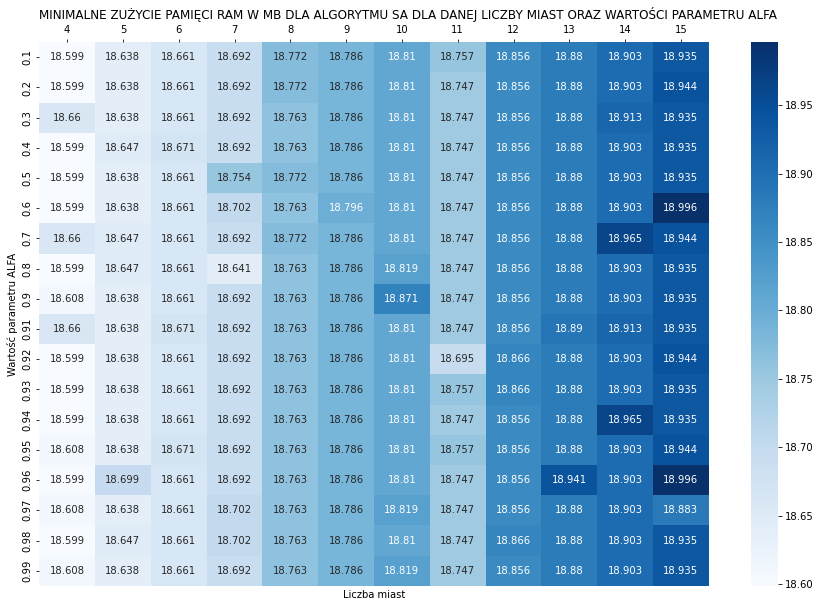

In [9]:
CSV_DATA_OBJECTS, NAMES = prepare_csv_data_objects(type_of_measure=TIME_AND_MEMORY,
                                                      name_of_dir_with_meassurements=NAME_DIR_WITH_RESULTS_CSV,
                                                      names_of_parameters=[ALPHA])
f, parameters_names = generate_dictionary_by_rows_with_specific_value_and_by_stats_from_feature(csv_data_objects=CSV_DATA_OBJECTS,
                                                                              name_of_parameter=ALPHA,
                                                                              column_name=NUMBER_OF_CITIES_COL,
                                                                              values_of_column_name=list(range(4, 16)),
                                                                              feature_column_name="used_memory_peak_diff_before_after_measurement_in_bytes",
                                                                              stat="min")
f = count_heat_table_values(f,type="bytes_to_mb")
f2 = pd.DataFrame.from_dict(f)
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax, fmt='.5g')
ax.xaxis.tick_top()
xticks_labels = [4,5,6,7,8,9,10,11,12,13,14,15]
yticks_labels = ALPHA_RANGE
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Liczba miast')
plt.ylabel('Wartość parametru ALFA')

# title
title = 'Minimalne zużycie pamięci RAM w MB dla algorytmu SA dla danej liczby miast oraz wartości parametru alfa'.upper()
plt.title(title, loc='left')

10. Mapa ciepła dla danej wartości parametrów alfa obrazującą średnie zużycie CPU zależne od ilości miast

Text(0.0, 1.0, 'ŚREDNIE ZUŻYCIE PAMIĘCI RAM W MB DLA ALGORYTMU SA DLA DANEJ LICZBY MIAST ORAZ WARTOŚCI PARAMETRU ALFA')

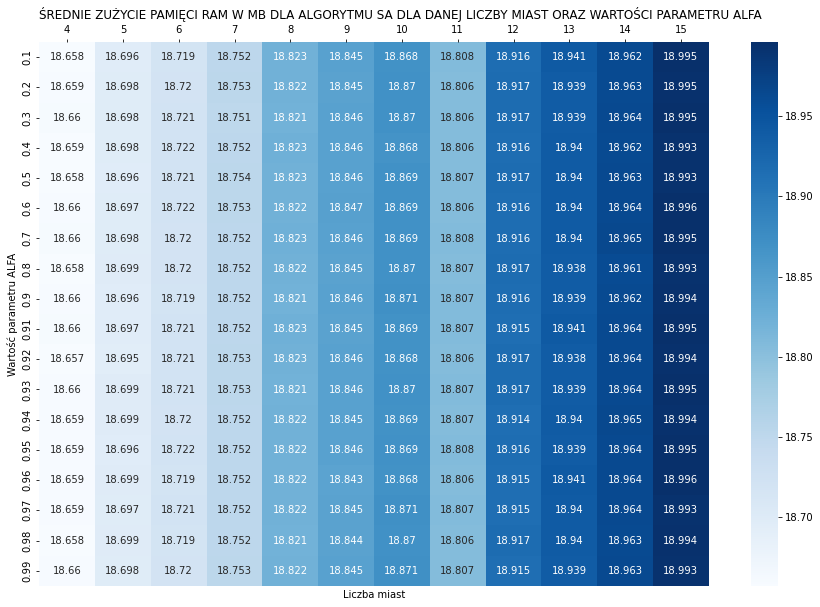

In [10]:
CSV_DATA_OBJECTS, _ = prepare_csv_data_objects(type_of_measure=TIME_AND_MEMORY,
                                                      name_of_dir_with_meassurements=NAME_DIR_WITH_RESULTS_CSV,
                                                      names_of_parameters=[ALPHA])
f, _ = generate_dictionary_by_rows_with_specific_value_and_by_stats_from_feature(csv_data_objects=CSV_DATA_OBJECTS,
                                                                              name_of_parameter=ALPHA,
                                                                              column_name=NUMBER_OF_CITIES_COL,
                                                                              values_of_column_name=list(range(4, 16)),
                                                                              feature_column_name="used_memory_peak_diff_before_after_measurement_in_bytes",
                                                                              stat="avg")
f = count_heat_table_values(f,type="bytes_to_mb")
f2 = pd.DataFrame.from_dict(f)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax, fmt='.5g')
ax.xaxis.tick_top()
xticks_labels = [4,5,6,7,8,9,10,11,12,13,14,15]
yticks_labels = ALPHA_RANGE
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Liczba miast')
plt.ylabel('Wartość parametru ALFA')

# title
title = 'Średnie zużycie pamięci RAM w MB dla algorytmu SA dla danej liczby miast oraz wartości parametru alfa'.upper()
plt.title(title, loc='left')

11. Mapa ciepła dla danej wartości parametrów alfa obrazującą maksymalne zużycie CPU zależne od ilości miast

Text(0.0, 1.0, 'MAKSYMALNE ZUŻYCIE PAMIĘCI RAM W MB DLA ALGORYTMU SA DLA DANEJ LICZBY MIAST ORAZ WARTOŚCI PARAMETRU ALFA')

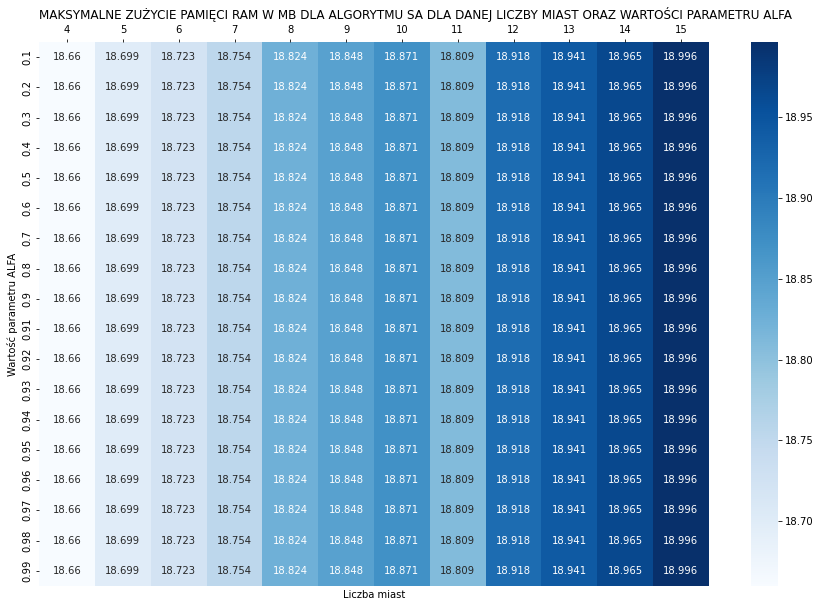

In [11]:
CSV_DATA_OBJECTS, _ = prepare_csv_data_objects(type_of_measure=TIME_AND_MEMORY,
                                                      name_of_dir_with_meassurements=NAME_DIR_WITH_RESULTS_CSV,
                                                      names_of_parameters=[ALPHA])
f, _ = generate_dictionary_by_rows_with_specific_value_and_by_stats_from_feature(csv_data_objects=CSV_DATA_OBJECTS,
                                                                              name_of_parameter=ALPHA,
                                                                              column_name=NUMBER_OF_CITIES_COL,
                                                                              values_of_column_name=list(range(4, 16)),
                                                                              feature_column_name="used_memory_peak_diff_before_after_measurement_in_bytes",
                                                                              stat="max")
f = count_heat_table_values(f,type="bytes_to_mb")
f2 = pd.DataFrame.from_dict(f)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(f2, cmap="Blues", annot=True, ax=ax, fmt='.5g')
ax.xaxis.tick_top()
xticks_labels = [4,5,6,7,8,9,10,11,12,13,14,15]
yticks_labels = ALPHA_RANGE
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('Liczba miast')
plt.ylabel('Wartość parametru ALFA')

# title
title = 'Maksymalne zużycie pamięci RAM w MB dla algorytmu SA dla danej liczby miast oraz wartości parametru alfa'.upper()
plt.title(title, loc='left')
